In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import math
import os
import random
from pandas_datareader import data as wb
import matplotlib.pyplot as plt
from datetime import datetime

function for defining the time period according to year month date as a format. Here distance is the specified parameter which is defined as 1 for daily, 7 for weekly and so on.

In [2]:
def period(start, end, distance = 1):
    s = start.split('-')
    e = end.split('-')
    y1 = int(s[0])
    m1 = int(s[1])
    d1 = int(s[2])
    y2 = int(e[0])
    m2 = int(e[1])
    d2 = int(e[2])
    dates = []
    dates.append(start)
    while((y1 < y2) or (y1 == y2 and m1 < m2) or (y1 == y2 and m1 == m2 and d1 <= d2 - distance)):
        if(np.isin(m1, [1,3,5,7,8,10])):
            d1 += distance
            if(d1 > 31):
                d1 = d1%31
                m1 += 1
        elif(m1 == 12):
            d1 += distance
            if(d1 > 31):
                d1 = d1%31
                m1 = 1
                y1 += 1
        elif(np.isin(m1, [4,6,9,11])):
            d1 += distance
            if(d1 > 30):
                d1 = d1%30
                m1 += 1
        elif(m1 == 2):
            d1 += distance
            if((y1/4 - math.floor(y1/4)) == 0):    #for leap year check
                if(d1 > 29):
                    d1 = d1%29
                    m1 += 1
            else:
                if(d1 > 28):
                    d1 = d1%28
                    m1 += 1
        else:
            print("Error: month > 12")
        dates.append(str(y1)+'-'+str(m1)+'-'+str(d1))
        df = pd.DataFrame(dates,columns=['Date'])   #here df is initialised with column as a date and here date is the list created above
        df['Date'] =  pd.to_datetime(df['Date'], format='%Y-%m-%d') 
        df = df.set_index(['Date'])
        #df = pd.to_datetime(df)
    return df
def month_list(start_date,end_date):     #just as how above we created a period list with dates, we have created a list for months according to years
    start_d = start_date.split('-')[2]
    start_m = start_date.split('-')[1]
    start_y = start_date.split('-')[0]
    end_d = end_date.split('-')[2]
    end_m = end_date.split('-')[1]
    end_y = end_date.split('-')[0]
    n_months = ((int(end_y) - int(start_y))*12) + ((int(end_m) - int(start_m))) #for calculating the total number of months between the start and end month
    months = []
    y = int(start_y) #eg year 2015
    for i in range(n_months):
        m = ((int(start_m) - 1 + i)%12) + 1
        if(((int(start_m)-1 + i)%12) == 0 and i != 0):
            y += 1 
        date = str(y) + '-' + str(m) + '-' + str(1)
        months.append(date)
    months = pd.DataFrame(months, columns=['Date'])
    months['Date'] =  pd.to_datetime(months['Date'], format='%Y-%m-%d')
    months = months.set_index(['Date'])
    return months

def load_table(path, dvd = True): #directories for paths of the csv files
    files = os.listdir(path)
    df_list = list()
    for i in range(len(files)):
        table = pd.read_csv(path+files[i],index_col='Date',parse_dates=True)[['Close']]
        name = files[i].replace(".csv","")
        table.columns = [name]
        df_list.append(table)
    df = df_list[0]
    for df_ in df_list[1:]:
        df = pd.concat([df,df_], axis=1)
    df.fillna(method='ffill',inplace=True)
    return df_list, df

def monthly_returns(price, start_date, end_date):
    months = month_list(start_date,end_date)
    returns_df = pd.DataFrame(months.index,columns=['Date'])
    for col in price.columns:
        values = []
        for i in range(len(months)-1):
            idx = price.loc[(price.index >= months.index[i]) & (price.index < months.index[i+1])].index #val of current month should be less than next month and more than previous month
            v = price.loc[idx,col].iloc[0]
            values = np.append(values,v)
            values = pd.DataFrame(values,columns=[col])
        returns_df = pd.concat([returns_df,values],axis=1)
    returns_df.drop(len(months)-1,axis=0,inplace=True)
    returns_df = returns_df.set_index("Date")
    returns = returns_df.pct_change()*100
    returns = returns.drop(returns.index[0], axis=0)
    return returns_df

def tree_to_table(tree, name_str):
    n_gen = len(tree)
    n_chrom = len(tree[0])
    name = []
    gen = []
    chrom = []
    ret = []
    vol = []
    sr = []
    res = []
    for i in range(n_gen):
        for j in range(n_chrom):
            name.append(name_str)
            gen.append(i)
            chrom.append(j)
            ret.append(tree[i][j].get_expected_return())
            vol.append(tree[i][j].get_volatility())
            sr.append(tree[i][j].get_sharpe_ratio())
    d = {'name': name, 'generation': gen, 'chromosome': chrom, 'return': ret, 'volatility': vol, 'sharpe_ratio': sr}
    df = pd.DataFrame(data=d)
    return df

In [3]:
class Portfolio:
    def __init__(self, returns_df, corr_matrix, risk_free):
        self.returns = returns_df #fn for no of month returns in form of rows and columns 
        self.corr = corr_matrix 
        self.description = self.returns.describe() #fn for describing monthly returns 
        self.n_assets = self.returns.shape[1] #fn for specifying how many columns are there in the monthly returns
        self.risk_free = risk_free
        self.initialize_weights()
        self.set_expected_return()
        self.set_volatility()
        self.set_sharpe_ratio()
        return None
    def initialize_weights(self):
        self.weights = np.random.rand(self.n_assets) #n_assets is the function that will be later used in mutation function
        self.weights = (self.weights/self.weights.sum()) 
        return None
    def set_weights(self, weights):
        self.weights = (weights/weights.sum())
        self.set_discrete_weights = self.weights
        return None
    def set_expected_return(self):
        weighted = self.weights*self.description.loc['mean']
        self.expected_return = weighted.sum().round(2)
        return None
    def set_volatility(self):
        std = self.description.loc['std'].values
        m1 = (self.weights*std).reshape(self.n_assets,1)
        m2 = m1.reshape(1,self.n_assets)
        self.volatility = math.sqrt((m1*self.corr*m2).sum())
        return None
    def set_sharpe_ratio(self):
        self.sharpe_ratio = (self.expected_return-self.risk_free)/self.volatility
        return None
    def get_weights(self):
        return self.weights
    def get_expected_return(self):
        return self.expected_return
    def get_volatility(self):
        return self.volatility
    def get_sharpe_ratio(self):
        return self.sharpe_ratio

In [4]:
class Genetic_algorithm:
    def __init__(self, returns_df, corr_matrix, risk_free, size):
        self.returns = returns_df
        self.corr = corr_matrix
        self.risk_free = risk_free
        self.size = size
        return None
    def run(self, iterations, variable):
        self.initialize()
        for i in range(iterations):
            self.set_fitness(variable)
            self.select_fittest()
            self.crossover()
            self.mutation()
            self.pass_generation(variable)
        return None
    def initialize(self):
        self.population = []
        self.offspring = []
        self.population_best = []
        self.population_fitness = []
        self.population_mean  = []
        self.tree = list()
        for i in range(self.size):
            self.population.append(Portfolio(self.returns, self.corr, self.risk_free))
        self.population_df = self.to_table(self.population)
        self.tree.append(self.population)
        return None
    def set_fitness(self, variable):
        if(variable == 'volatility'): #fitness function is sharpe ratio
            max_volatility = self.population_df[variable].max()
            self.population_df.sort_values(by=variable, inplace=True, ascending=True)
            self.population_df['fitness'] = max_volatility - self.population_df[variable] + 1
            self.population_df['fitness'] = self.population_df['fitness']/self.population_df['fitness'].sum()
        else:
            self.population_df.sort_values(by=variable, inplace=True, ascending=False)
            self.population_df['fitness'] = self.population_df[variable]/self.population_df[variable].sum()
        self.population_df['selection_prob'] = self.population_df['fitness']
        for i in range(1, len(self.population_df['selection_prob'])):
            self.population_df['selection_prob'].iloc[i] = self.population_df['selection_prob'].iloc[i-1] + self.population_df['selection_prob'].iloc[i]
        return self.population_df
    def select_fittest(self, rand = True):
        third = int(self.size/3)
        idx = self.population_df.head(third).index.values
        if(rand == True):
            for i in idx:
                self.offspring.append(self.population[i])
                p = Portfolio(self.returns, self.corr, self.risk_free)
                self.offspring.append(p)
        else:
            for i in idx:
                self.offspring.append(self.population[i])
        return None
    def crossover(self):
        rest = self.size - len(self.offspring)
        for i in range(rest):
            idx_parent1 = self.select_parent()
            idx_parent2 = self.select_parent()
            alpha = random.random()
            w3 = alpha*self.population[idx_parent1].get_weights() + (1-alpha)*self.population[idx_parent2].get_weights()
            p = Portfolio(self.returns, self.corr, self.risk_free)
            p.set_weights(w3)
            self.offspring.append(p)
        return None
    def mutation(self):
        n_assets = len(self.population[0].get_weights())
        for child in self.offspring:
            idx1 = random.randrange(0,n_assets)
            idx2 = random.randrange(0,n_assets)
            w = child.get_weights()
            minimo = min(w[idx1],w[idx2])
            rand = random.uniform(0,minimo)
            w[idx1] += rand
            w[idx2] -= rand
            child.set_weights(w)
        return None
    def pass_generation(self, variable):
        self.population = self.offspring
        self.offspring = []
        self.population_df = self.to_table(self.population)
        self.tree.append(self.population)
        best = self.population[0]
        mean_fit = self.population_df[variable].mean()
        if(variable == 'volatility'):
            max_fit = self.population_df.sort_values(by=variable, ascending=True).head(1)[variable].iloc[0]
        else:
            max_fit = self.population_df.sort_values(by=variable, ascending=False).head(1)[variable].iloc[0]
        self.population_best.append(best)
        self.population_fitness.append(max_fit)
        self.population_mean.append(mean_fit)
        return None
    def select_parent(self):
        roulette = random.random()
        i = 0
        while roulette > self.population_df['selection_prob'].iloc[i]: 
            i += 1
        if(i > 0):
            i = i - 1
        return self.population_df.iloc[i,:].name
    def to_table(self, array):
        exp_returns = [s.get_expected_return() for s in array]
        volatilities = [s.get_volatility() for s in array]
        sharpe_ratios = [s.get_sharpe_ratio() for s in array]
        d = {'return': exp_returns, 'volatility': volatilities, 'sharpe_ratio' : sharpe_ratios}
        df = pd.DataFrame(data=d) 
        return df
    def get_samples(self):
        return self.samples
    def get_population(self,variable):
        self.population_df.sort_values(by=variable, inplace=True, ascending=False)
        idx = self.population_df.head(1).index.values[0]
        return self.population[idx]
    def get_tree(self, variable):
        return self.tree
    def get_analysis(self):
        d = {'best_fitness':self.population_fitness,'fitness_mean':self.population_mean}
        output = pd.DataFrame(data=d) 
        return output
folder = "../Python/data/historical_data/"

start_date = '2019-5-29'
end_date = '2021-7-1'

stock_names = ['AAPL', 'ADBE', 'AMZN','BTC-USD', 'FB', 'GC=F', '^IRX','MSFT', 'NVDA', 'QCOM','TSLA','TXN']

risk_free = 1.28

In [5]:
df_list, df = load_table(folder)
daily = period('2019-5-31', end_date, distance=1)
stock_price = pd.merge(daily, df, on='Date', how='left')
stock_price.fillna(method='ffill',inplace=True)
months = month_list('2019-6-1',end_date)
monthly_price = pd.merge(months, stock_price, on='Date', how='left')
monthly_returns = monthly_price.pct_change()*100
monthly_returns = monthly_returns.drop(monthly_returns.index[0], axis=0)
corr = monthly_returns.corr()
corr_matrix = corr.values

(12.5, -0.5)

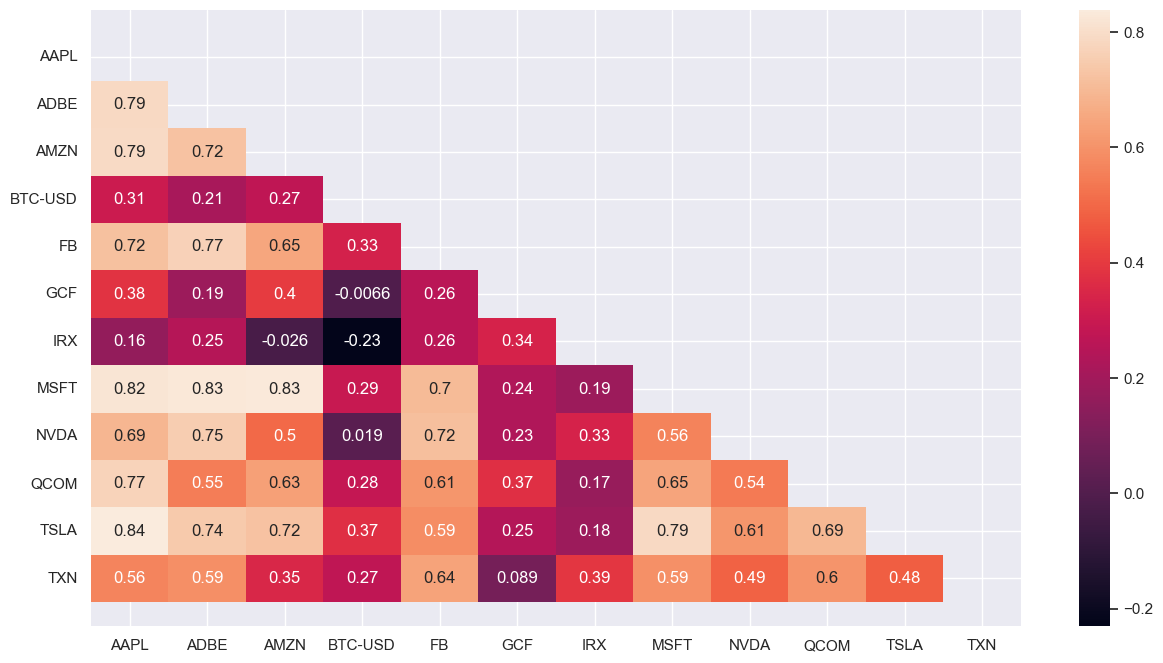

In [6]:
sns.set()
plt.figure(figsize=(15,8))
mask = np.triu(np.ones_like(corr, dtype=bool))
ax = sns.heatmap(data=corr, annot=True, mask=mask)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

In [7]:
population_size = 50
n_generations = 100
GA = Genetic_algorithm(monthly_returns, corr_matrix, risk_free, population_size)

In [8]:
variable = 'return' #expected return
GA.run(n_generations,variable)
tree1 = GA.get_tree(variable)
analysis1 = GA.get_analysis()
variable = 'volatility'
GA.run(n_generations,variable)
tree2 = GA.get_tree(variable)
analysis2 = GA.get_analysis()
variable = 'sharpe_ratio'
GA.run(n_generations,variable)
tree3 = GA.get_tree(variable)
analysis3 = GA.get_analysis()

In [ ]:
result1_df = tree_to_table(tree1, 'tree_1')
result2_df = tree_to_table(tree2, 'tree_2')
result3_df = tree_to_table(tree3, 'tree_3')
results_df = pd.concat([result1_df, result2_df, result3_df])

In [ ]:
results_df.sort_values(by = ['return','volatility'], inplace=True, ascending=[False,True])
b1 = results_df.head(1)
results_df

,name,generation,chromosome,return,volatility,sharpe_ratio
2031,tree_3,40,31,7.50,11.594009,0.536484
2050,tree_3,41,0,7.50,11.594009,0.536484
2100,tree_3,42,0,7.50,11.594009,0.536484
2150,tree_3,43,0,7.50,11.594009,0.536484
2200,tree_3,44,0,7.50,11.594009,0.536484
...,...,...,...,...,...,...
1325,tree_2,26,25,1.51,16.347274,0.014070
3119,tree_1,62,19,1.41,14.022049,0.009271
1589,tree_1,31,39,1.30,12.809769,0.001561
325,tree_3,6,25,0.98,13.424459,-0.022347


In [ ]:
results_df.sort_values(by = ['volatility','return'], inplace=True, ascending=[True,False])
b2 = results_df.head(1)
results_df

,name,generation,chromosome,return,volatility,sharpe_ratio
1719,tree_2,34,19,2.59,6.104168,0.214607
1750,tree_2,35,0,2.59,6.104168,0.214607
1800,tree_2,36,0,2.59,6.104168,0.214607
1850,tree_2,37,0,2.59,6.104168,0.214607
1900,tree_2,38,0,2.59,6.104168,0.214607
...,...,...,...,...,...,...
1848,tree_3,36,48,4.05,14.792936,0.187252
2593,tree_1,51,43,3.70,14.897606,0.162442
4843,tree_1,96,43,4.09,15.284079,0.183851
4105,tree_1,82,5,3.94,15.515392,0.171443


In [ ]:
results_df.sort_values(by = ['volatility','return'], inplace=True, ascending=[True,False])
b2 = results_df.head(1)
results_df

,name,generation,chromosome,return,volatility,sharpe_ratio
1719,tree_2,34,19,2.59,6.104168,0.214607
1750,tree_2,35,0,2.59,6.104168,0.214607
1800,tree_2,36,0,2.59,6.104168,0.214607
1850,tree_2,37,0,2.59,6.104168,0.214607
1900,tree_2,38,0,2.59,6.104168,0.214607
...,...,...,...,...,...,...
1848,tree_3,36,48,4.05,14.792936,0.187252
2593,tree_1,51,43,3.70,14.897606,0.162442
4843,tree_1,96,43,4.09,15.284079,0.183851
4105,tree_1,82,5,3.94,15.515392,0.171443


In [ ]:
results_df.sort_values(by='sharpe_ratio', inplace=True, ascending=False)
b3 = results_df.head(1)
results_df

,name,generation,chromosome,return,volatility,sharpe_ratio
3100,tree_1,62,0,7.38,11.346205,0.537625
3800,tree_1,76,0,7.38,11.346205,0.537625
2450,tree_1,49,0,7.38,11.346205,0.537625
4300,tree_1,86,0,7.38,11.346205,0.537625
4250,tree_1,85,0,7.38,11.346205,0.537625
...,...,...,...,...,...,...
1325,tree_2,26,25,1.51,16.347274,0.014070
3119,tree_1,62,19,1.41,14.022049,0.009271
1589,tree_1,31,39,1.30,12.809769,0.001561
325,tree_3,6,25,0.98,13.424459,-0.022347


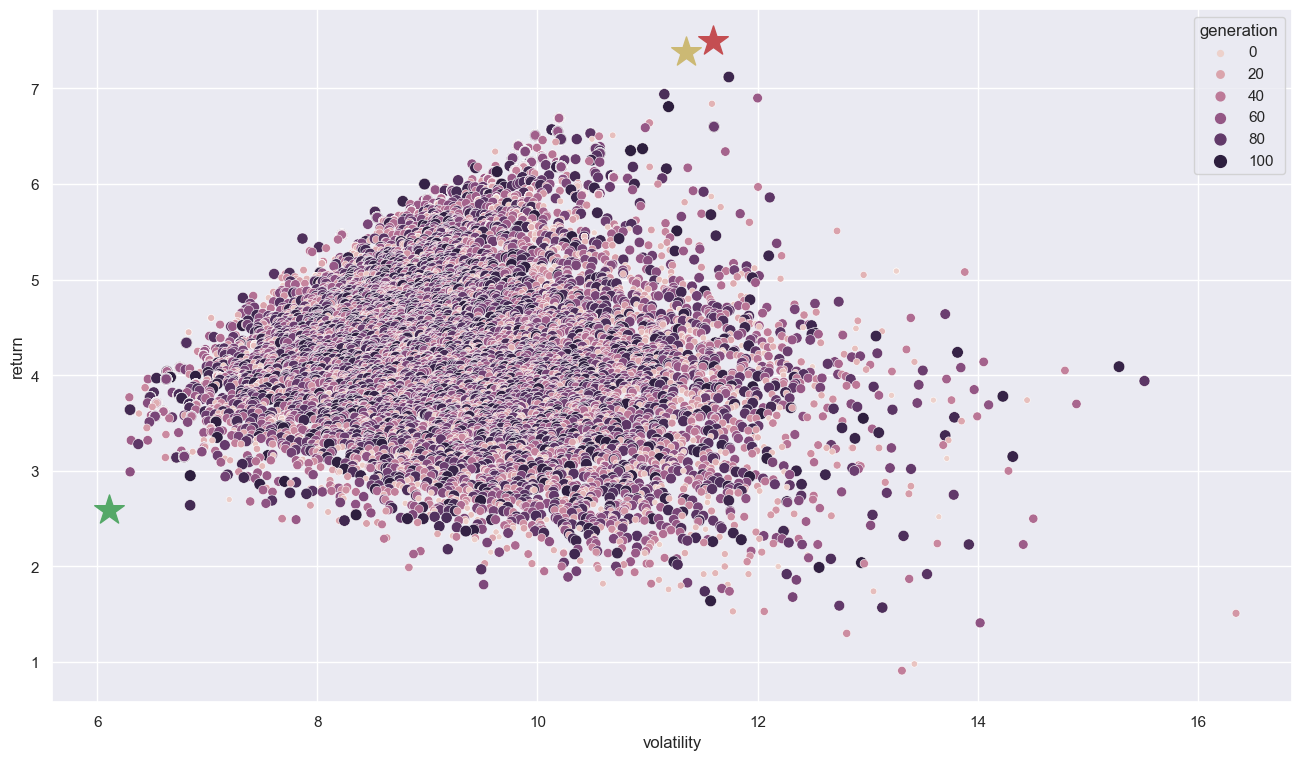

In [ ]:
plt.figure(figsize=(16,9))
sns.scatterplot(x = results_df['volatility'],y = results_df['return'], size=results_df['generation'], hue=results_df['generation']) #, style=results_df['name'])
plt.scatter(x = b1['volatility'].iloc[0], y = b1['return'].iloc[0], marker = '*', color = 'r', s =500, label = 'Max E[Retorno]')
plt.scatter(x = b2['volatility'].iloc[0], y = b2['return'].iloc[0], marker = '*', color = 'g', s =500, label = 'Max E[Retorno]')
plt.scatter(x = b3['volatility'].iloc[0], y = b3['return'].iloc[0], marker = '*', color = 'y', s =500, label = 'Max E[Retorno]')

In [ ]:
best_portfolios = pd.concat([b1,b2,b3])
best_portfolios

,name,generation,chromosome,return,volatility,sharpe_ratio
2031,tree_3,40,31,7.50,11.594009,0.536484
1719,tree_2,34,19,2.59,6.104168,0.214607
3100,tree_1,62,0,7.38,11.346205,0.537625


In [ ]:
w1 = tree2[best_portfolios['generation'].iloc[0]][best_portfolios['chromosome'].iloc[0]].get_weights()
w2 = tree2[best_portfolios['generation'].iloc[1]][best_portfolios['chromosome'].iloc[1]].get_weights()
w3 = tree1[best_portfolios['generation'].iloc[2]][best_portfolios['chromosome'].iloc[2]].get_weights()
d = {'stock_name': stock_names, 'Weights_Portfolio_return_maxi': w1, 'Weights_Portfolio_volatility_mini': w2, 'Weights_Portfolio_sharpratio_optimo': w3}
best_portfolios_weights = pd.DataFrame(data=d)
best_portfolios_weights

,stock_name,Weights_Portfolio_return_maxi,Weights_Portfolio_volatility_mini,Weights_Portfolio_sharpratio_optimo
0,AAPL,0.138283,0.002164,0.000006
1,ADBE,0.120974,0.000006,0.017730
2,AMZN,0.077416,0.266195,0.035719
3,BTC-USD,0.089696,0.000424,0.030960
4,FB,0.049302,0.157700,0.020257
5,GC=F,0.122557,0.106140,0.453402
6,^IRX,0.096528,0.015816,0.172612
7,MSFT,0.021680,0.007099,0.000043
8,NVDA,0.067904,0.000001,0.213078
9,QCOM,0.117699,0.040174,0.001677
